In [ ]:
!git clone https://github.com/lopuhin/kaggle-dsbowl-2018-dataset-fixes.git

In [ ]:
!pip install apoc

In [ ]:
!sudo apt-get install -y nvidia-driver-470

In [ ]:
!clinfo

In [ ]:
import os
from skimage.io import imread, imshow
import numpy as np
import matplotlib.pyplot as plt
import shutil
from PIL import Image
import cv2
from collections import Counter
import apoc
import pyclesperanto_prototype as cle

In [ ]:
# Set up folders for images and masks

images_folder = "images/"
masks_folder = "masks/"
dataset_folder = "kaggle-dsbowl-2018-dataset-fixes/stage1_train"

os.makedirs(images_folder, exist_ok=True)
os.makedirs(masks_folder, exist_ok=True)

In [ ]:
# Copy images to `images_folder`

def copy_images(source_dir, dest_dir):
  image_index = 1

  for folder in os.listdir(source_dir):
    images_path = os.path.join(source_dir, folder, "images")

    image_file = os.listdir(images_path)[0]
    image_path = os.path.join(images_path, image_file)

    image = Image.open(image_path)
    image = image.convert("L") # make image grayscale
    image.save(os.path.join(dest_dir, f"{image_index:04d}.png"))

    image_index += 1

copy_images(dataset_folder, images_folder)

In [ ]:
# Combine and copy masks to `masks_folder`

def combine_masks(masks_folder):
    first_mask_path = os.path.join(masks_folder, os.listdir(masks_folder)[0])

    first_mask = cv2.imread(first_mask_path, cv2.IMREAD_GRAYSCALE)
    height, width = first_mask.shape

    combined_mask = np.ones((height, width), dtype=np.uint8)

    for mask_file in os.listdir(masks_folder):
        mask_path = os.path.join(masks_folder, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        combined_mask[mask == 255] = 2

    return combined_mask

def copy_masks(source_dir, dest_dir):
  mask_index = 1

  for folder in os.listdir(source_dir):
    masks_folder = os.path.join(source_dir, folder, "masks")

    combined_mask = combine_masks(masks_folder)
    combined_mask_path = os.path.join(dest_dir, f"{mask_index:04d}.png")

    cv2.imwrite(combined_mask_path, combined_mask)

    mask_index += 1

copy_masks(dataset_folder, masks_folder)

In [ ]:
# Function to get an array with sizes of all images in a directory

def get_img_sizes(source_dir):
    img_sizes = []

    for image_name in os.listdir(source_dir):
        image_path = os.path.join(source_dir, image_name)

        image = imread(image_path)

        img_sizes.append(image.shape)

    return img_sizes

# Count unique items
counter = Counter(get_img_sizes("images"))

# Print unique items and their counts
for item, count in counter.items():
    print(f"{item}: {count}")

(256, 256): 334
(360, 360): 90
(603, 1272): 6
(260, 347): 3
(520, 696): 90
(256, 320): 111
(1024, 1024): 16
(512, 640): 13
(1040, 1388): 1


In [ ]:
# Function to check if an image is grayscale

def is_grayscale(image):
    # Check if the image has only one channel (grayscale)
    if len(image.shape) == 2:
        return True
    # Check if all the channels have the same values
    elif len(image.shape) == 3 and image.shape[2] == 3:
        b, g, r = cv2.split(image)
        return (b == g).all() and (b == r).all()
    else:
        return False

In [ ]:
# Function to check if an image is 256x256 pixels

def is_correct_size(image):
    if image.shape[0] == 256 and image.shape[1] == 256:
        return True
    else:
        return False

In [ ]:
# Function to check if an image is grayscale and 256x256

def passes_filter(image_path):
  image = cv2.imread(image_path)

  if is_grayscale(image) and is_correct_size(image):
    return True
  else:
    return False

In [ ]:
# Set up folders for filtered images and masks

filtered_images_folder = "filtered_images/"
filtered_masks_folder = "filtered_masks/"

os.makedirs(filtered_images_folder, exist_ok=True)
os.makedirs(filtered_masks_folder, exist_ok=True)

In [ ]:
# Function to filter image according to the above-defined filter

def filter_images_and_masks():
  for image_name in os.listdir(images_folder):
        image_path = os.path.join(images_folder, image_name)
        mask_path = os.path.join(masks_folder, image_name)

        if passes_filter(image_path):
          shutil.copy(image_path, os.path.join(filtered_images_folder, image_name))
          shutil.copy(mask_path, os.path.join(filtered_masks_folder, image_name))

filter_images_and_masks()

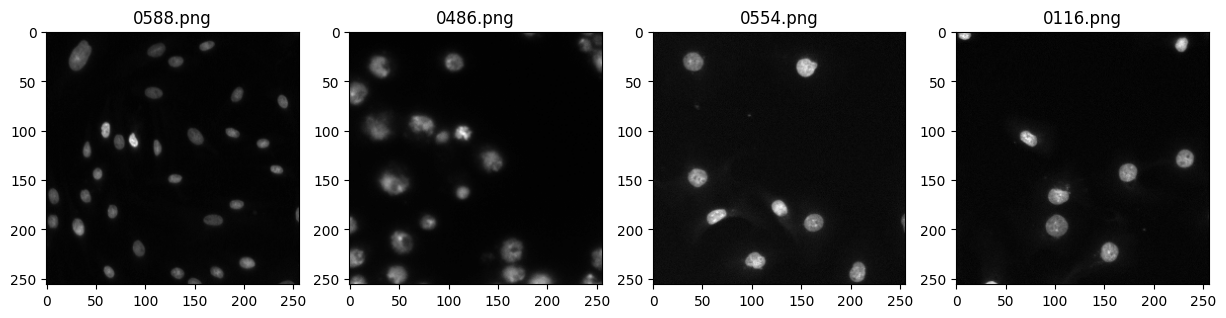

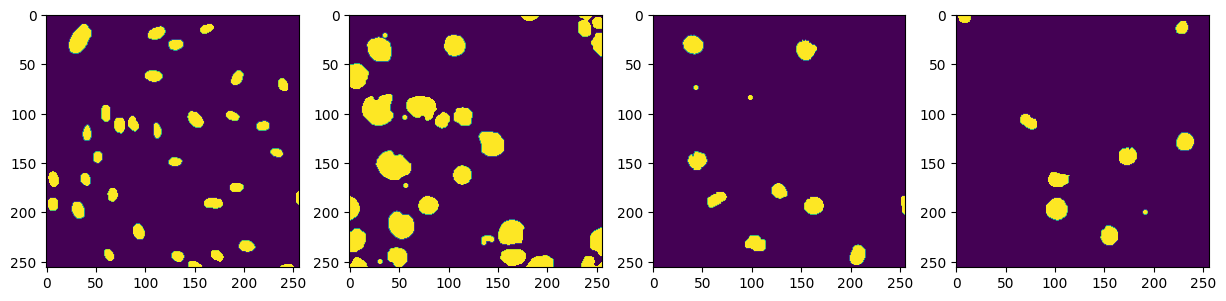

In [ ]:
file_list = os.listdir(filtered_images_folder)

# show first 4 images
fig, axs = plt.subplots(1, 4, figsize=(15,15))
for i, filename in enumerate(file_list[:4]):
    image = imread(filtered_images_folder + filename)
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(filename)
plt.show()

# show corresponding label images
fig, axs = plt.subplots(1, 4, figsize=(15,15))
for i, filename in enumerate(file_list[:4]):
    masks = imread(filtered_masks_folder + filename)
    axs[i].imshow(masks)
plt.show()

In [ ]:
# Set up folders for training images and masks

train_images_folder = "train_images/"
train_masks_folder = "train_masks/"

os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_masks_folder, exist_ok=True)

for image_name in os.listdir(filtered_images_folder)[:30]:

    source_path = os.path.join(filtered_images_folder, image_name)
    destination_path = os.path.join(train_images_folder, image_name)
    shutil.copyfile(source_path, destination_path)

    source_path = os.path.join(filtered_masks_folder, image_name)
    destination_path = os.path.join(train_masks_folder, image_name)
    shutil.copyfile(source_path, destination_path)

In [ ]:
# setup classifer and where it should be saved
segmenter = apoc.ObjectSegmenter(opencl_filename="model.cl")

# setup feature set used for training
features = apoc.PredefinedFeatureSet.object_size_1_to_5_px.value

# train classifier on folders
apoc.train_classifier_from_image_folders(
    segmenter,
    features,
    image = "train_images/",
    ground_truth = "train_masks/")

In [ ]:
def compute_iou(mask1, mask2):
    binary_mask1 = (mask1 != 0).astype(int)
    binary_mask2 = (mask2 != 0).astype(int)

    # Compute intersection (logical AND)
    intersection = np.logical_and(binary_mask1, binary_mask2)

    # Compute union (logical OR)
    union = np.logical_or(binary_mask1, binary_mask2)

    # Compute IoU
    iou = np.sum(intersection) / np.sum(union)

    return iou

/usr/local/lib/python3.10/dist-packages/pyclesperanto_prototype/_tier9/_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


IoU: 0.8353162179085786


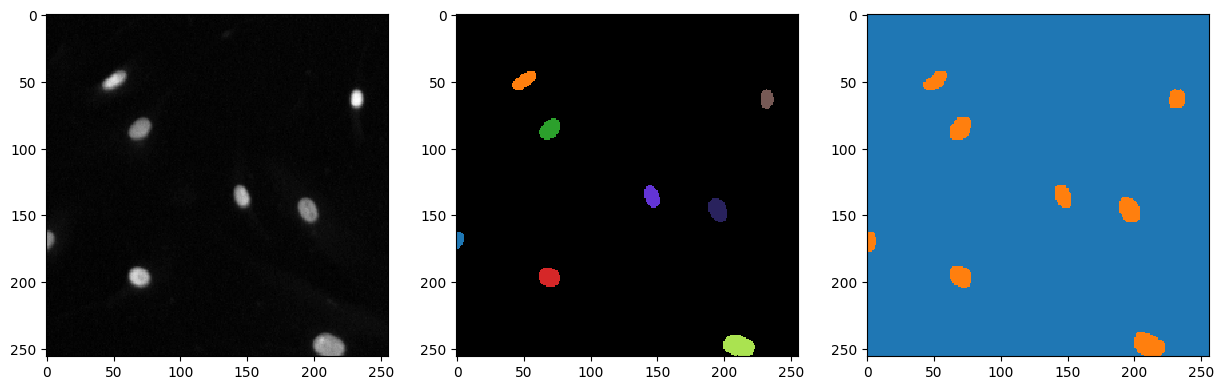

IoU: 0.8756476683937824


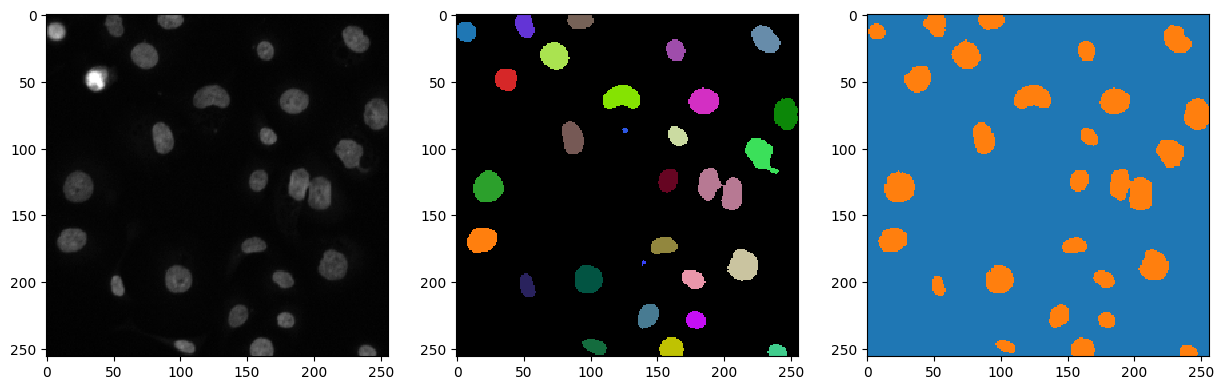

IoU: 0.8738738738738738


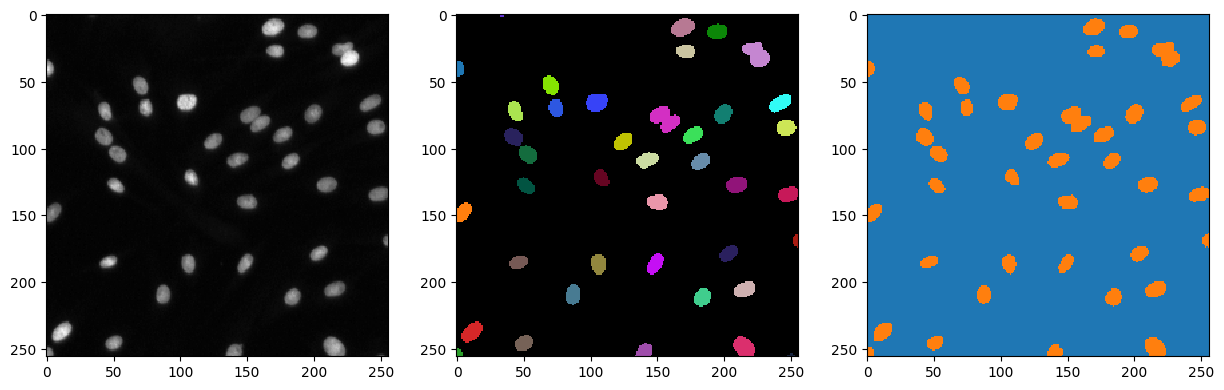

IoU: 0.6979166666666666


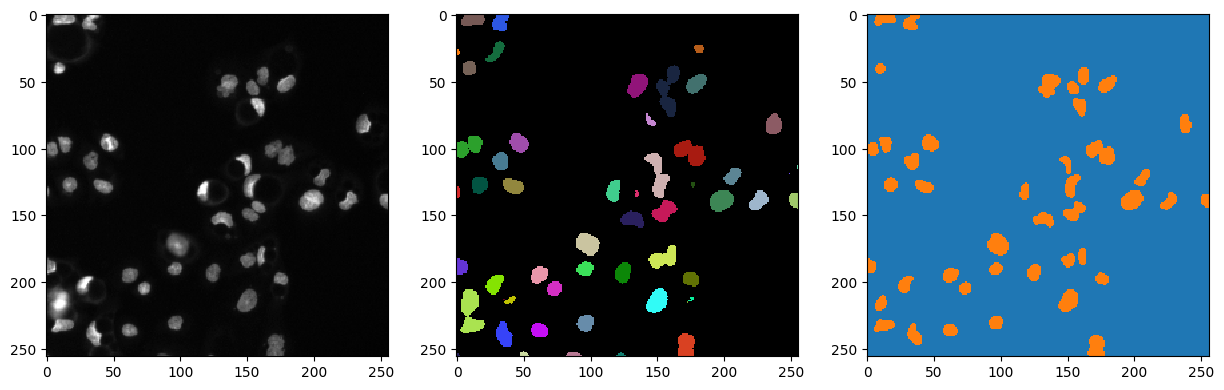

IoU: 0.873647006847802


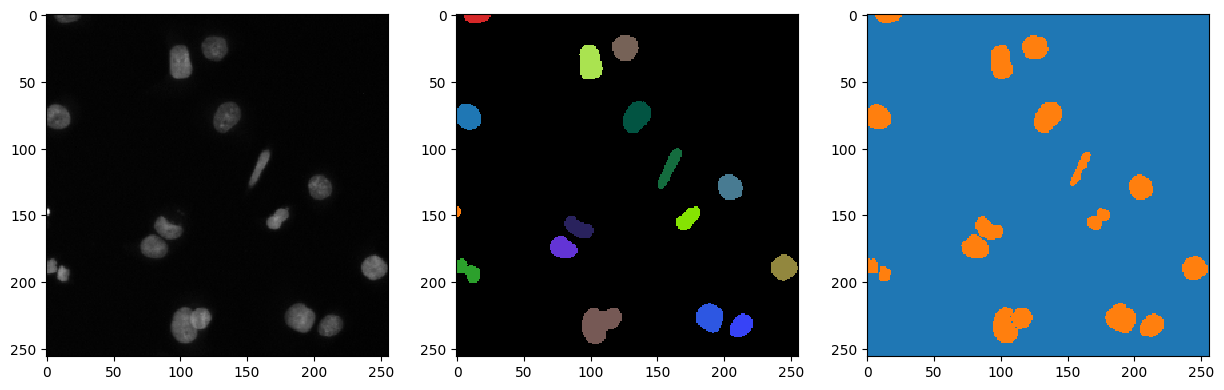

IoU: 0.619520264681555


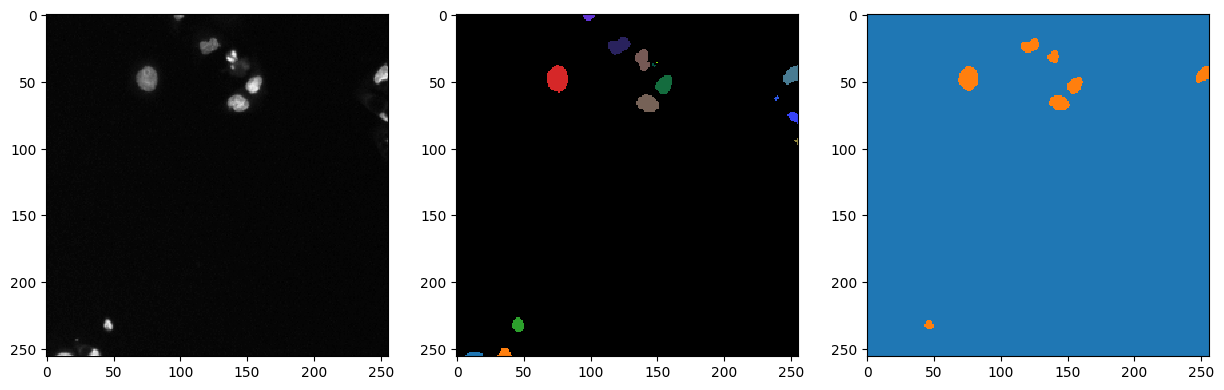

IoU: 0.6957040572792362


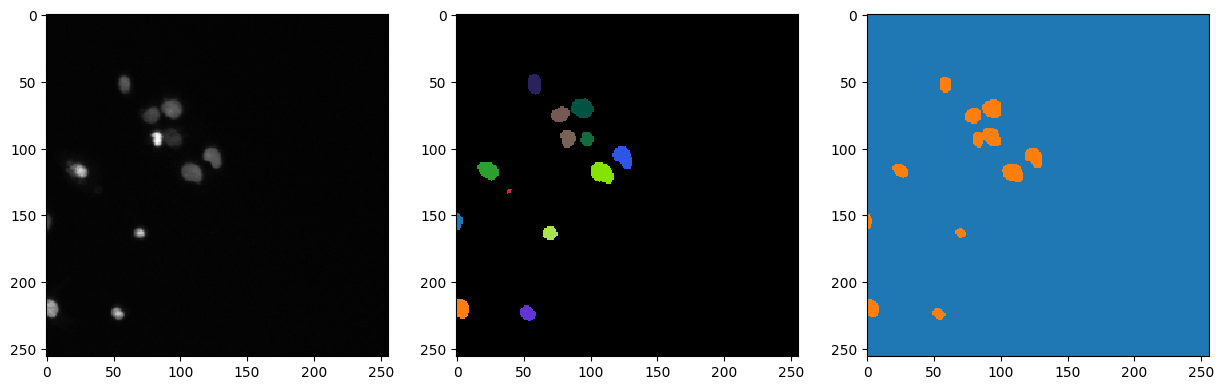

IoU: 0.8413843888070692


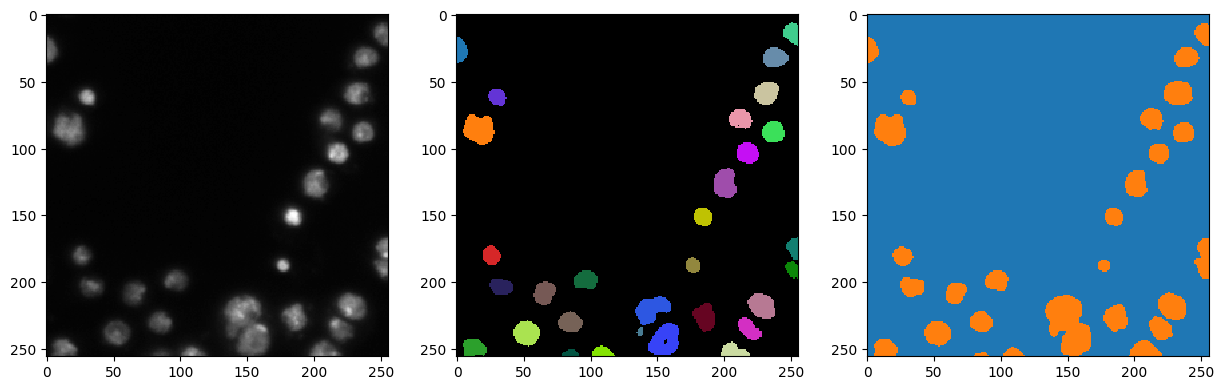

IoU: 0.7416753174159546


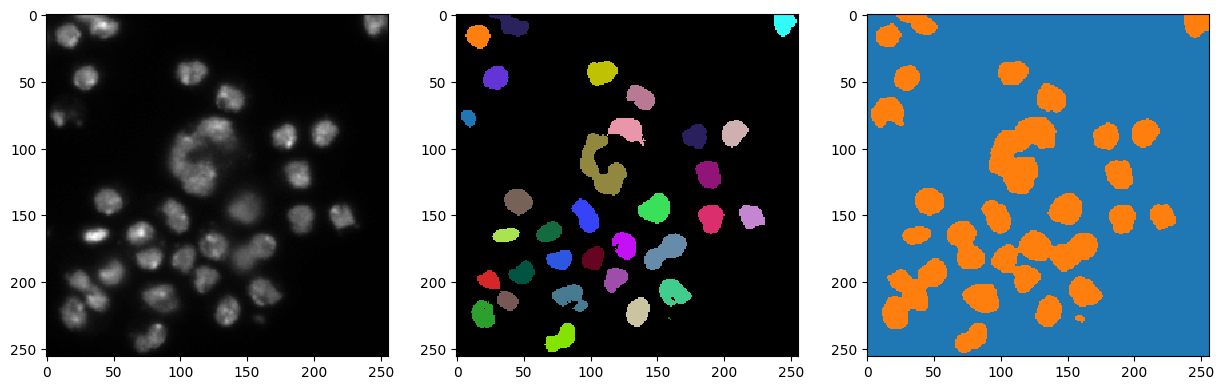

IoU: 0.9051929490233445


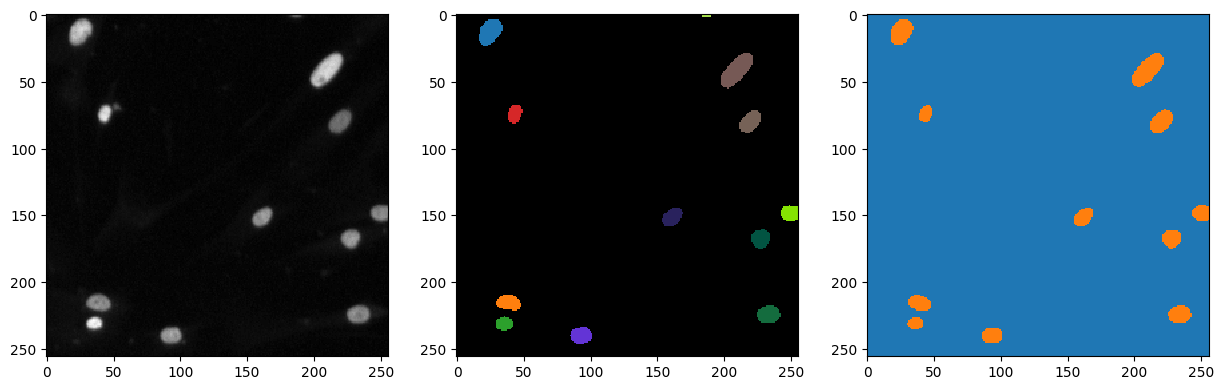

In [ ]:
# show predictions of images 100-110
for i, filename in enumerate(os.listdir(filtered_images_folder)[100:110]):
    fig, axs = plt.subplots(1, 3, figsize=(15,15))

    image = imread(filtered_images_folder + filename)
    cle.imshow(image, plot=axs[0])

    labels = segmenter.predict(image)
    cle.imshow(labels, plot=axs[1], labels=True)

    mask = imread(filtered_masks_folder + filename)
    cle.imshow(mask, plot=axs[2], labels=True)

    print("IoU:", compute_iou(np.array(labels), mask-1))

    plt.show()

In [ ]:
# compute all IoUs

ious = []

for i, filename in enumerate(os.listdir(filtered_images_folder)):
    image = imread(filtered_images_folder + filename)

    labels = segmenter.predict(image)
    mask = imread(filtered_masks_folder + filename)

    iou = compute_iou(np.array(labels), mask-1)
    ious.append(iou)

    print(f"{i}. IoU for {filename}", iou)

0. IoU for 0588.png 0.8644033340109778
1. IoU for 0486.png 0.5940737440124764
2. IoU for 0554.png 0.8803489821354383
3. IoU for 0116.png 0.869281045751634
4. IoU for 0523.png 0.8010254387694735
5. IoU for 0552.png 0.6433513368745257
6. IoU for 0155.png 0.8092783505154639
7. IoU for 0214.png 0.9268755935422602
8. IoU for 0444.png 0.8918808649530804
9. IoU for 0149.png 0.8727897838899804
10. IoU for 0553.png 0.8327495621716288
11. IoU for 0599.png 0.8458781362007168
12. IoU for 0436.png 0.5676432170181004
13. IoU for 0529.png 0.802632932222565
14. IoU for 0064.png 0.8467374810318664
15. IoU for 0621.png 0.45680573114201434
16. IoU for 0132.png 0.7450189155107187
17. IoU for 0041.png 0.7629958960328317
18. IoU for 0337.png 0.7786276223776224
19. IoU for 0652.png 0.8780974081458274
20. IoU for 0036.png 0.7185443283004259
21. IoU for 0295.png 0.7840325086649934
22. IoU for 0620.png 0.8162518301610542
23. IoU for 0254.png 0.8934762471880375
24. IoU for 0264.png 0.884760366182014
25. IoU for 

Mean IoU: 0.7752
Median IoU: 0.8038
Standard Deviation IoU: 0.1132
Minimum IoU: 0.4568
Maximum IoU: 0.9359


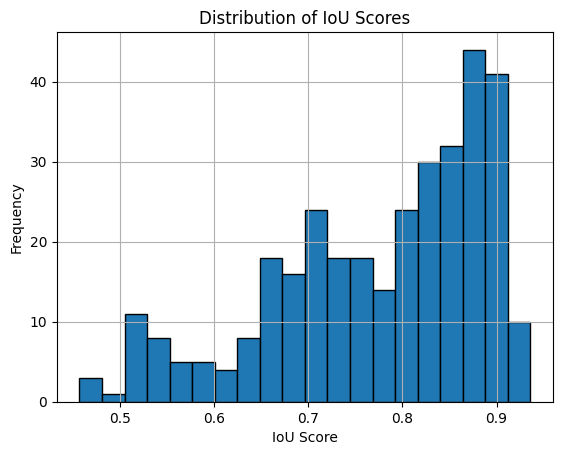

In [ ]:
# Calculate summary statistics
mean_iou = np.mean(ious)
median_iou = np.median(ious)
std_iou = np.std(ious)
min_iou = np.min(ious)
max_iou = np.max(ious)

# Print summary statistics
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Median IoU: {median_iou:.4f}")
print(f"Standard Deviation IoU: {std_iou:.4f}")
print(f"Minimum IoU: {min_iou:.4f}")
print(f"Maximum IoU: {max_iou:.4f}")

# Plot histogram of IoU scores
plt.hist(ious, bins=20, edgecolor='black')
plt.title('Distribution of IoU Scores')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


IoU: 0.45680573114201434


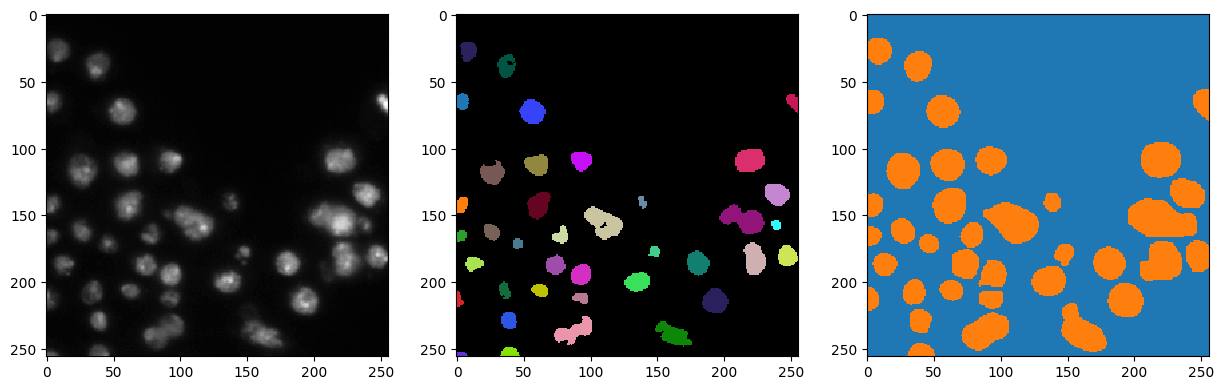

In [ ]:
# Show worst prediction

min_index = min(range(len(ious)), key=ious.__getitem__)

for i, filename in enumerate(os.listdir(filtered_images_folder)[min_index:min_index+1]):
    fig, axs = plt.subplots(1, 3, figsize=(15,15))

    image = imread(filtered_images_folder + filename)
    cle.imshow(image, plot=axs[0])

    labels = segmenter.predict(image)
    cle.imshow(labels, plot=axs[1], labels=True)

    mask = imread(filtered_masks_folder + filename)
    cle.imshow(mask, plot=axs[2], labels=True)

    print("IoU:", compute_iou(np.array(labels), mask-1))

    plt.show()

IoU: 0.9359236537150648


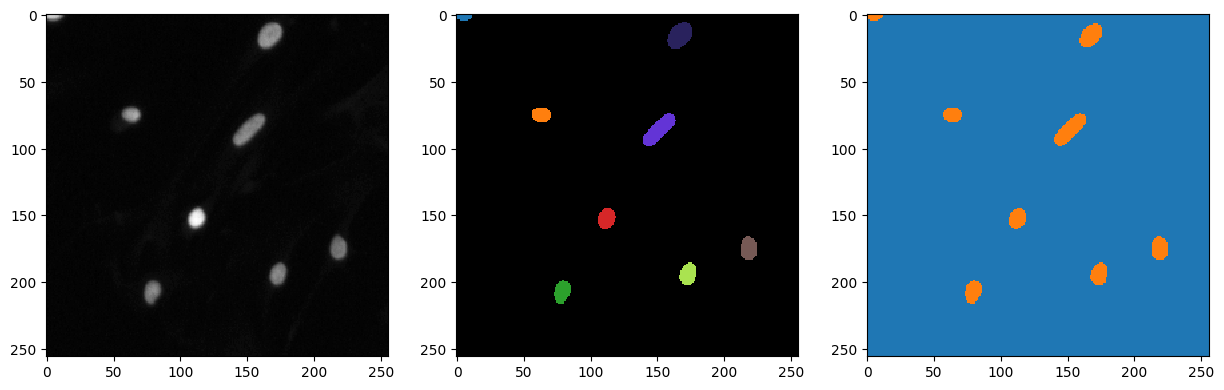

In [ ]:
# Show best prediction

max_index = max(range(len(ious)), key=ious.__getitem__)

for i, filename in enumerate(os.listdir(filtered_images_folder)[max_index:max_index+1]):
    fig, axs = plt.subplots(1, 3, figsize=(15,15))

    image = imread(filtered_images_folder + filename)
    cle.imshow(image, plot=axs[0])

    labels = segmenter.predict(image)
    cle.imshow(labels, plot=axs[1], labels=True)

    mask = imread(filtered_masks_folder + filename)
    cle.imshow(mask, plot=axs[2], labels=True)

    print("IoU:", compute_iou(np.array(labels), mask-1))

    plt.show()